# IPEDS Restructuring Example

Admissions data downloaded from the IPEDS Data Center

In [4]:
# install.packages('janitor')
library(tidyverse)

In [5]:
df <- read_csv('data/ipeds_admissions_data.csv', name_repair = janitor::make_clean_names)

head(df)

Rows: 11 Columns: 192
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): institution_name
dbl (190): unit_id, applicants_total_adm2021, applicants_men_adm2021, applic...
lgl   (1): x

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


unit_id,institution_name,applicants_total_adm2021,applicants_men_adm2021,applicants_women_adm2021,admissions_total_adm2021,admissions_men_adm2021,admissions_women_adm2021,enrolled_total_adm2021,enrolled_men_adm2021,⋯,applicants_total_ic2001,applicants_men_ic2001,applicants_women_ic2001,admissions_total_ic2001,admissions_men_ic2001,admissions_women_ic2001,enrolled_total_ic2001,enrolled_men_ic2001,enrolled_women_ic2001,x
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
217156,Brown University,46568,18032,28536,2568,1276,1292,1705,859,⋯,16606,6860,9746,2693,1210,1483,1377,616,761,NA
190150,Columbia University in the City of New York,61110,25463,35647,2524,1231,1293,1641,808,⋯,0,NA,NA,0,NA,NA,0,0,0,NA
190415,Cornell University,67380,33488,33892,5852,2613,3239,3718,1670,⋯,16538,9244,7294,4288,2393,1895,1950,1085,865,NA
182670,Dartmouth College,28356,13256,15100,1750,871,879,1221,598,⋯,10188,5579,4609,2181,1122,1059,1084,569,515,NA
166027,Harvard University,57786,26981,30805,2318,1100,1218,1951,925,⋯,18932,9549,9383,2028,1040,988,1563,810,753,NA
166683,Massachusetts Institute of Technology,33240,21672,11568,1365,665,700,1177,604,⋯,10490,7560,2930,1787,968,819,1030,604,426,NA


### Wide to Long

First need to drop last column that seems to always be added to these downloads. Then we will pivot the data so that we can extract the Year and the items from the default column names.

In [6]:
dfl <- df %>% 
  select(-last_col()) %>% 
  pivot_longer(-c(unit_id, institution_name), names_to = 'Item', values_to = 'Value')

head(dfl)

unit_id,institution_name,Item,Value
<dbl>,<chr>,<chr>,<dbl>
217156,Brown University,applicants_total_adm2021,46568
217156,Brown University,applicants_men_adm2021,18032
217156,Brown University,applicants_women_adm2021,28536
217156,Brown University,admissions_total_adm2021,2568
217156,Brown University,admissions_men_adm2021,1276
217156,Brown University,admissions_women_adm2021,1292


There are many ways we could parse `Item` to get information we need. Here is a simple way to get the year and group. 

In [7]:
dfl2 <- dfl %>% 
  mutate(
    # get digits
    Year = str_extract(Item, "\\d+"),
    # first group of letters
    adm_group = str_extract(Item, "^([a-z]+)")
         )

# print values extracted
table(dfl2$Year); table(dfl2$adm_group)


2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 
  99   99   99   99   99   99   99   99   99   99   99   99   99   99   99   99 
2017 2018 2019 2020 2021 
  99   99   99   99   99 


admissions applicants   enrolled 
       693        693        693 

In [8]:
head(dfl2)

unit_id,institution_name,Item,Value,Year,adm_group
<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
217156,Brown University,applicants_total_adm2021,46568,2021,applicants
217156,Brown University,applicants_men_adm2021,18032,2021,applicants
217156,Brown University,applicants_women_adm2021,28536,2021,applicants
217156,Brown University,admissions_total_adm2021,2568,2021,admissions
217156,Brown University,admissions_men_adm2021,1276,2021,admissions
217156,Brown University,admissions_women_adm2021,1292,2021,admissions


In this example, we'll then just use the totals

In [10]:
dfl3 <- dfl2 %>% 
  filter(str_detect(Item, "total")) %>% 
  select(-unit_id, -Item)

head(dfl3)

institution_name,Value,Year,adm_group
<chr>,<dbl>,<chr>,<chr>
Brown University,46568,2021,applicants
Brown University,2568,2021,admissions
Brown University,1705,2021,enrolled
Brown University,36793,2020,applicants
Brown University,2822,2020,admissions
Brown University,1756,2020,enrolled


### Long to Wide

We are now at point where it might be easier to pivot back to a wider dataframe so we can create admit rate and yield rate.

In [13]:
final_stats <- dfl3  %>% 
pivot_wider(names_from = adm_group, values_from = Value) %>% 
mutate(admit_rate = admissions / applicants,
yield = enrolled / admissions)

head(final_stats)

institution_name,Year,applicants,admissions,enrolled,admit_rate,yield
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Brown University,2021,46568,2568,1705,0.05514516,0.6639408
Brown University,2020,36793,2822,1756,0.07669937,0.6222537
Brown University,2019,38674,2733,1662,0.07066763,0.6081229
Brown University,2018,35437,2718,1656,0.07669949,0.6092715
Brown University,2017,32723,2779,1637,0.08492498,0.5890608
Brown University,2016,32390,3014,1681,0.09305341,0.5577306


### Function for plotting your school vs. the peer group average

In [34]:
 admit_rate_plot <- function(x) {
    final_stats %>% 
    mutate(grp = ifelse(str_detect(institution_name, x), x, 'Peer Avg'),
    grp = fct_relevel(grp, 'Peer Avg', after=Inf),
    Year = as.integer(Year)) %>% 
    summarise(admit_rate = mean(admit_rate, na.rm = TRUE), .by = c(Year, grp)) %>% 
    ggplot(aes(Year, admit_rate, col=grp, shape=grp)) + 
    geom_line() + 
    geom_point() +
    scale_y_continuous(labels = scales::percent) +
    theme_minimal() +
    theme(legend.title = element_blank()) +
    labs(y = "Admit Rate")
}

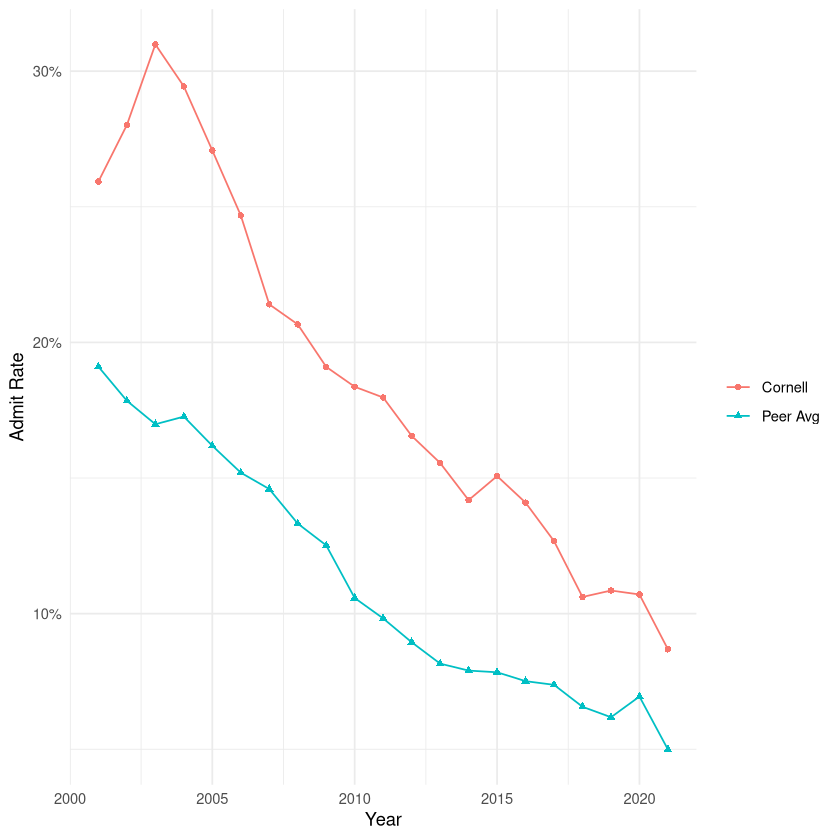

In [35]:
admit_rate_plot('Cornell')

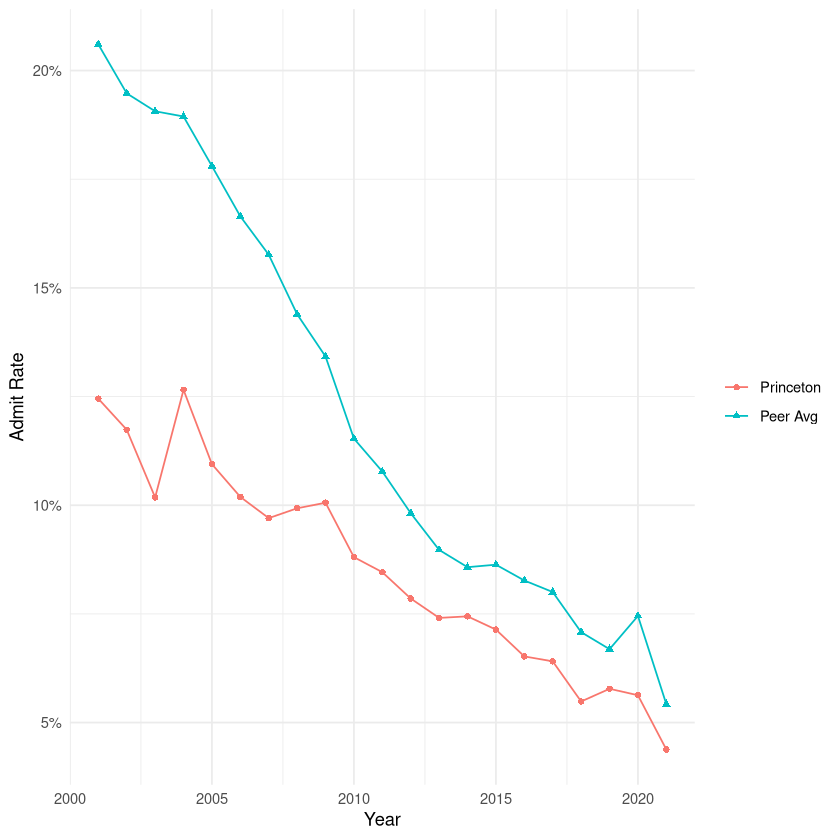

In [36]:
admit_rate_plot('Princeton')